# Install & Import

In [2]:
# import packages
import tensorflow as tf
import numpy as np
import json
import pandas as pd
import math
import cv2
import os
import glob
from IPython.display import clear_output
import seaborn as sns

# import modules
from pycocotools.coco import COCO
from pprint import pprint
from matplotlib import pyplot as plt

# this was imported for multipose, we may not need it for our purposes
import tensorflow_hub as hub

# initialize MoveNet

In [3]:
# initialize TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_thunder_3.tflite")

# pre-allocate tensors to the model (necessary for TFLite model)
interpreter.allocate_tensors()

In [4]:
interpreter.get_input_details()

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3], dtype=int32),
  'shape_signature': array([  1, 256, 256,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [5]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3], dtype=int32),
  'shape_signature': array([ 1,  1, 17,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# make MoveNet predictions

- 17 keypoints (in the order of: **[nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]**)
- **Note: model output is y,x not x,y**

In [6]:
# single video predictions

def movenet_single_vid(path):

    # create connection to single video
    cap = cv2.VideoCapture(path)
    output = []

    while cap.isOpened(): #while connection is open
        ret, frame = cap.read() #read frame by frame

        # break while loop once no more frames
        if frame is None:
            break

        # Reshape image
        img = frame.copy()
        # add an extra dimension along axis 0 TO resize with pad 
        img = tf.image.resize(np.expand_dims(img, axis=0), (256,256))
        # re-cast tensor as float32 as this is the type that the model requires as input
        input_image = tf.cast(img, dtype=tf.float32) 

        # fetch input and output details from TFLite interpreter
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # MAKE PREDICTIONS
        # setting input details equal to input image
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        # get predictions
        interpreter.invoke() 
        # creating output variable from 'index' in output_details
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index']) 
        # store keypoints in output list
        output.append(np.array(np.squeeze(keypoints_with_scores)))

    cap.release()
    
    output_denorm = []
    
    # denormalise output
    for frame in output:
        output_denorm.append(np.array(frame*([192,192,1])))
    
    # convert output to integer
    output_denorm_int = np.array(output_denorm).astype(int)
    
    return np.array(output_denorm_int)

path = "000002.mp4"
test_path = 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0/000027.mp4'
output = movenet_single_vid(path)

print('Output Shape \n', output.shape, '\n')
print('Example Frame Output (x,y,conf): \n', 'NB. Model output is y,x not x,y \n' ,output[0])

2023-01-04 10:15:19.080930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Output Shape 
 (278, 17, 3) 

Example Frame Output (x,y,conf): 
 NB. Model output is y,x not x,y 
 [[136  89   0]
 [136  89   0]
 [139  87   0]
 [150  92   0]
 [138 121   0]
 [ 86  97   0]
 [138 119   0]
 [ 84 121   0]
 [ 84  82   0]
 [ 88 111   0]
 [ 80  80   0]
 [129 146   0]
 [ 94  92   0]
 [140 103   0]
 [139  91   0]
 [154  99   0]
 [134  89   0]]


In [7]:
# make predictions for ALL videos

def movenet_folders(path):
    
    paths = {}
    folders_kp_pred = {}
    
    # list of sub-folders "infinityai_fitness_basic_***_v1.0" in folder "InfinityAI Data"
    folders = glob.glob(path+'/infinityai_fitness_basic_*_v1.0', recursive = True)
    folder_count = len(folders)
    
    # print sub-folders found
    print(folder_count, "folders found")
    pprint(folders)
    
    # list of files in subfolder "***.mp4"
    for folder in folders:
        
        # instantiate empty list for each sub-folder
        paths[folder] = []
        
        # list of paths for each file in sub-folder
        files = sorted(glob.glob(folder+'/*.mp4', recursive = True))
        
        # store list of pathnames for files
        paths[folder] = files
        
        # isolate exercise name
        ex_name = folder.split("_")[-2]
        
        folders_kp_pred[ex_name] = {}
        
        #iterate through files in current folder
        for ind_file, file in enumerate(paths[folder]):
            
            # extract video number
            vid_num = file.split("/")[-1]
            vid_num = str(vid_num.split(".")[0])
            
            # predict frame keypoints with selected model
            video_kp_pred = movenet_single_vid(file)
            
            # append dictionary with video kp predictions per frame
            folders_kp_pred[ex_name][vid_num] = list(video_kp_pred)
            
            print("VIDEO COMPLETE:", ex_name, vid_num)
            
        print("!!! FOLDER COMPLETE: ", ex_name)
    
    print("___ALL FOLDERS COMPLETE___")
    
    return folders_kp_pred

path = "InfinityAI Data"
test_directory = "Test Files"

#folders_kp_pred_test = movenet_folders(test_directory)
folders_kp_pred = movenet_folders(path)

10 folders found
['InfinityAI Data/infinityai_fitness_basic_curl_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0',
 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
VIDEO COMPLETE: curl 000000
VIDEO COMPLETE: curl 000001
VIDEO COMPLETE: curl 000002
VIDEO COMPLETE: curl 000003
VIDEO COMPLETE: curl 000004
VIDEO COMPLETE: curl 000005
VIDEO COMPLETE: curl 000006
VIDEO COMPLETE: curl 000007
VIDEO COMPLETE: curl 000008
VIDEO COMPLETE: curl 000009
VIDEO COMPLETE: curl 000010
VIDEO COMPLETE: curl 000011
VIDEO COMPLETE: curl 000012
VIDEO COMPLETE: curl 000013
VIDEO 

# Notes

In [86]:
# example frame extraction from prediction dictionary
pprint(folders_kp_pred['armraise']['000000'][0])

array([[ 84, 122,   0],
       [ 82, 121,   0],
       [ 82, 122,   0],
       [ 83, 121,   0],
       [ 83, 121,   0],
       [ 93, 119,   0],
       [ 93, 125,   0],
       [106, 120,   0],
       [106, 126,   0],
       [115, 124,   0],
       [115, 122,   0],
       [115, 121,   0],
       [115, 122,   0],
       [132, 123,   0],
       [132, 119,   0],
       [151, 124,   0],
       [151, 117,   0]])


- folders (n) ex_names
- videos (n) vid_no
- frames (n) fra_no
- kps (17) kp_no / kp_name
- xyz (3) x,y,z

# single video: extract annotations from JSON: kp preds, bbox coordinates & calculate torso diameter

JSON labels: The COCO bounding box format is **[top left x position, top left y position, width, height]**.

MN Pred: The first two channels of the last dimension represents the yx coordinates (normalized to image frame, i.e. range in [0.0, 1.0]) of the 17 keypoints (in the order of: [[0]nose, [1]left eye, [2]right eye, [3]left ear, [4]right ear, [5]left shoulder, [6]right shoulder, [7]left elbow, [8]right elbow, [9]left wrist, [10]right wrist, [11]left hip, [12]right hip, [13]left knee, [14]right knee, [15]left ankle, [16]right ankle]).

In [8]:
# create list of video bbox coordinates per frame

json_path = '000002.json'
json_path_error = 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0/000027.json'

def json_single(json_path):
    
    coco = COCO(json_path)
    
    bbox_true_per_frame = []

    for img_data in coco.imgs.values():
        img_id = img_data["id"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            
            # skip non-person instances
            if ann["category_id"] != 0:
                continue
            frame_bbox = ann["bbox"]
            bbox_true_per_frame.append(frame_bbox)

    keypoints_true_per_frame = []
    torso_diam_per_frame = []

    for img_data in coco.imgs.values():
        img_id = img_data["id"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            
            # skip non-person instances
            if ann["category_id"] != 0:
                continue
            keypoints = np.array(ann["keypoints"])
            keypoints = np.reshape(keypoints, (17, 3))
            keypoints_true_per_frame.append(keypoints)
            
            # calculate frame 'torso diameter'
            right_hip = keypoints[12][:2]
            left_shoul = keypoints[5][:2]
            
            x = abs(right_hip[0] - left_shoul[0])
            y = abs(right_hip[1] - left_shoul[1])
            
            torso_diam_single_frame = np.sqrt( (x)**2 + (y)**2 )
            torso_diam_per_frame.append(torso_diam_single_frame)
    
    return bbox_true_per_frame, keypoints_true_per_frame, torso_diam_per_frame

true_bbox, true_anns, torso_diam = json_single(json_path)

print('bbox COCO format \n', true_bbox[0], '\n')
print('bbox labels shape \n', (np.array(true_bbox)).shape, '\n')
print('anns \n', true_anns[0], '\n')
print('frame labels shape\n', true_anns[0].shape, '\n')
print('video labels shape\n', (np.array(true_anns)).shape, '\n')
print('tors_diam \n', torso_diam[0], '\n')

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
bbox COCO format 
 [132.01, 153.01, 27.980000000000018, 11.980000000000018] 

bbox labels shape 
 (278, 4) 

anns 
 [[157 163   1]
 [155 160   1]
 [153 160   1]
 [  0   0   0]
 [  0   0   0]
 [161 170   1]
 [147 171   1]
 [159 168   1]
 [134 169   1]
 [159 160   1]
 [141 159   1]
 [151 181   1]
 [138 179   1]
 [145 178   1]
 [139 157   2]
 [136 192   1]
 [138 165   1]] 

frame labels shape
 (17, 3) 

video labels shape
 (278, 17, 3) 

tors_diam 
 24.698178070456937 



# calculate accuracy threshold

- either PDJ with 'torso diameter', or PCKh with 'bone head link'
- can calculate PDJ, can't calculate PCKh
- however, prefer PCKh over PDJ - dilemma - as it is more accuarate and more commonly used in literature

- therefore, can use PDJ and justify - best to confirm with Lina first
- or, can find out if head box possible (this might be answered by Lina, should I ask Eric?)
- also, 

# PDJ (error using torso diameter)
## 1. calculate error between predicted and label
## 2. compare error to torso diameter

Image coordinates (x,y), visibility (v), and depth from camera (z, in meters) for each degree-of-freedom in the underlying SMPL-X model. Visibility values indicate whether keypoints are outside the image frame and not occluded from view (0), inside or outside the image frame and occluded from view (1), or **inside the image frame and not occluded from view (2)**. Note: keypoints that are outside the image frame will have x/y values outside the image dimensions.

In [9]:
# determine frame PDJ based on all keypoints
def PDJ_all_kp(frame_kp_labels, frame_kp_pred, threshold, frame_torso_diam):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):

        # x distance
        kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
        # y distance
        kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )
        # z distance
        kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

        # record distance for each keypoint, for each frame
        kp_acc.append(kp_dist)

        # record whether distance is above or below threshold (predicted or not)
        kp_acc.append( bool(kp_dist < threshold*frame_torso_diam) )
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc


# determine frame PDJ based on visibility choice
def PDJ_vis_kp(frame_kp_labels, frame_kp_pred, visibility, threshold, frame_torso_diam):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):
        
        if kp[2] == visibility:

            # x distance
            kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
            # y distance
            kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )
            # z distance
            kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

            # record distance for each keypoint, for each frame
            kp_acc.append(kp_dist)

            # record whether distance is above or below threshold (predicted or not)
            kp_acc.append( bool(kp_dist < threshold*frame_torso_diam) )
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc


            
# for a single video: for each frame, for each keypoint, calculate euclidean difference between predicted and actual
def frame_acc(frame_kp_pred, frame_kp_labels, threshold, frame_torso_diam, visibility=None):
    
    """ visibility = None is all keypoints
        visibility = 0 is keypoints are outside the image frame and not occluded from view
        visibility = 1 is keypoints are inside or outside the image frame and occluded from view
        visibility = 2 is keypoints are inside the image frame and not occluded from view 
        visibility = a2o is, all keypoints of frame are 2 (inside the image frame and not occluded from view) """
    
    kp_acc = []
    
    # if visibility = all, calculate distance of every keypoint
    if visibility == None:
        
        kp_acc = PDJ_all_kp(frame_kp_labels, frame_kp_pred, threshold, frame_torso_diam)
        
    # if visibility = N, calculate distance at N keypoints
    elif visibility in [0, 1, 2]:
        
        kp_acc = PDJ_vis_kp(frame_kp_labels, frame_kp_pred, visibility, threshold, frame_torso_diam)
    
    """
    # a20 is frames with all 2's only
    elif visibility == 'a2o':
        
        visibility = 2
        kp_acc = PDJ_vis_kp(frame_kp_labels, frame_kp_pred, visibility, threshold, frame_torso_diam)
        
        # if len(kp_acc) = 17, continue with frame, else ignore/discard frame
        if len(kp_acc) != 17:
            return 0 """
    
    # count correctly predicted keypoints
    i = 0
    
    for kp in kp_acc:
        if kp[1] == 1:
            i += 1
        else:
            continue
    
    if len(kp_acc) > 0:
        frame_mean_accuracy = ( i / len(kp_acc) )*100

    else:
        frame_mean_accuracy = 0.0
    
    return frame_mean_accuracy

results = frame_acc(output[0], true_anns[0], 0.5, torso_diam[0], 1)

# print("shape:\n", results.shape)
print("frame acc.:\n", results)

frame acc.:
 0.0


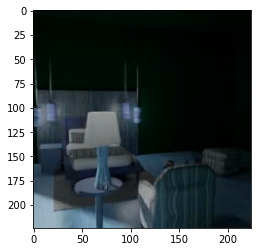

In [10]:
# Visualize single frame with labels and predictions
# [1] function which can display a single frame from a chosen video, with its predictions overlaid
# [2] same function with predictions in one color and labels in another

filename = "000002.mp4"

cap = cv2.VideoCapture(filename)
cap.set(1,0);  # (
success = cap.grab()
ret, image = cap.retrieve()
plt.figure(2)
plt.imshow(image)

# PCK (error using bounding box max side length

In [11]:
# PCK frame accuracy for visibility parameter None (all keypoints)
def pck_all_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):
            
        # diff_x = pred_x - actual_x
        kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
        # diff_y = pred_y - actual_y
        kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )

        # distance = sqrt( x2 + y2 )
        kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

        # record distance for each keypoint, for each frame
        kp_acc.append(kp_dist)

        # record whether distance is above or below threshold (predicted or not)
        kp_acc.append( bool(kp_dist < threshold*bbox_max) )
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc
            
# PCK frame accuracy for selected visibility parameter
def pck_vis_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max, visibility):
    
    kp_acc = []
    
    for kp_ind, kp in enumerate(frame_kp_labels):
        
        ## if keypoint label is in full view, then...
        if kp[2] == visibility:
            #print('valid')

            # diff_x = pred_x - actual_x
            kp_dist_x = abs( frame_kp_pred[kp_ind][1] - frame_kp_labels[kp_ind][0] )
            # diff_y = pred_y - actual_y
            kp_dist_y = abs( frame_kp_pred[kp_ind][0] - frame_kp_labels[kp_ind][1] )

            # distance = sqrt( x2 + y2 )
            kp_dist = math.sqrt( (kp_dist_x)**2 + (kp_dist_y)**2 )

            # record distance for each keypoint, for each frame
            kp_acc.append(kp_dist)

            # record whether distance is above or below threshold (predicted or not)
            kp_acc.append( bool(kp_dist < threshold*bbox_max) )

        ## elif keypoint is not in full view, skip...
        else:
            continue
    
    half_len = int((len(kp_acc) / 2)) 
    kp_acc = np.reshape(np.array(kp_acc), (half_len ,2))
    
    return kp_acc
    
# for a single frame: calculate the accuracy using difference between predicted and actual, and bounding box max side length (PCK@1, PCK@0.5, PCK@0.25)
def frame_acc_bbox(frame_kp_pred, frame_kp_labels, threshold, true_bbox, visibility=None):
    
    #pprint('pred: ')
    #print( frame_kp_pred )
    #print('labels: ')
    #print(frame_kp_labels)
    #print('bbox: ', true_bbox )
    
    kp_acc = []
    
    bbox_w = true_bbox[2]
    bbox_h = true_bbox[3]
    
    # determine max side length of bbox (bbox_max)
    if bbox_w > bbox_h:
        bbox_max = bbox_w
    else:
        bbox_max = bbox_h
    
    #print('bbox_max: ', bbox_max)
    
    # if visibility = all, calculate distance of every keypoint
    if visibility == None:
        
        kp_acc = pck_all_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max)
    
    # if visibility = N, calculate distance at N keypoints
    elif visibility in [0, 1, 2]:
        
        kp_acc = pck_vis_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max, visibility)
    
    """
    elif visibility == 'a2o':
        
        visibility = 2
        kp_acc = pck_vis_kp(frame_kp_pred, frame_kp_labels, threshold, bbox_max, visibility)
        
        # if len(kp_acc) = 17, continue with frame, else ignore/discard frame
        if len(kp_acc) != 17:
            return 0 """
    
    i = 0
    
    for kp in kp_acc:
        if kp[1] == 1:
            i += 1
        else:
            continue
    
    if len(kp_acc) > 0:
        frame_mean_accuracy = ( i / len(kp_acc) )*100 ### <- CHECK HERE, change len(kp_diff) to half_len
    
    else:
        frame_mean_accuracy = 0
    
    return frame_mean_accuracy

results = frame_acc_bbox(output[0], true_anns[0], 1, true_bbox[0])

# print("shape:\n", results.shape)
print("frame acc.:\n", results)

frame acc.:
 0.0


# Global function

In [12]:
# function for parsing through videos in folder (model, path, threshold)

def video_folder_predictions(directory, metric, threshold, visibility=None):
    # visibility = None is ALL keypoints
    # visibility = 0 is keypoints are outside the image frame and not occluded from view
    # visibility = 1 is inside or outside the image frame and occluded from view
    # visibility = 2 is inside the image frame and not occluded from view
    
    paths = {}
    results_global_mean = []
    results_per_vid = []
    results_per_folder = []
  
    # list of sub-folders "infinityai_fitness_basic_***_v1.0" in folder "InfinityAI Data"
    folders = glob.glob(directory+'/infinityai_fitness_basic_*_v1.0', recursive = True)
    print(folders)
    
    folder_mean_acc = []
    
    # list of files in subfolder "***.mp4"
    for folder in folders:
        paths[folder] = []
        files = sorted(glob.glob(folder+'/*.mp4', recursive = True))
        paths[folder] = files
        
        folder_accs_per_vid = []
        
        # isolate exercise name
        ex_name = folder.split("_")[-2]
        print(ex_name)
        
        #iterate through files in current folder
        for ind_file, file in enumerate(paths[folder]):
            
            # initiate empty list for video frame accuracies
            single_video_pred = []
            
            # extract video number
            vid_num = file.split("/")[-1]
            vid_num = str(vid_num.split(".")[0])
            
            # create json pathname
            video_json_path = folder + "/" + vid_num + ".json"
            
            # extract json labels
            video_bbox_labels, video_kp_labels, video_torso_diam = json_single(video_json_path)
                
            # fetch predicted frame keypoints
            print(type(ex_name))
            print(vid_num)
            video_kp_pred = folders_kp_pred[ex_name][vid_num][:]
            
            # frame by frame, 
            
            vid_accs_per_frame = []
            
            for frame_ind, frame in enumerate(video_kp_pred):
                
                # compare predictions to labels for each video
                frame_kp_labels = video_kp_labels[frame_ind] # <- NOTE, ISSUE HERE, LIST INDEX OUT OF RANGE WAS ERROR for 'bicyclecrunch 000026'
                frame_kp_pred = video_kp_pred[frame_ind]

                # retrieve frame bbox
                frame_bbox_labels = video_bbox_labels[frame_ind]

                # retrieve frame torso diameter
                frame_torso_diam = video_torso_diam[frame_ind]
                
                if metric == 'pdj':
                    
                    # determine accuracy with vis, threshold, torso_diam
                    frame_accuracy = frame_acc(frame_kp_pred, frame_kp_labels, threshold, frame_torso_diam, visibility)
                    
                    vid_accs_per_frame.append(frame_accuracy)
                
                elif metric == 'pck':
                    
                    # determine accuracy with vis, threshold, bbox_maxlength
                    frame_accuracy = frame_acc_bbox(frame_kp_pred, frame_kp_labels, threshold, frame_bbox_labels, visibility)
                    
                    vid_accs_per_frame.append(frame_accuracy)                    

            
            vid_acc = np.mean(vid_accs_per_frame)
            #print("vid_acc:", vid_acc)
            
            # store video accuracy
            folder_accs_per_vid.append(vid_acc)
            #results[ex_name][vid_num] = vid_acc
            results_per_vid.append([ex_name, vid_num, vid_acc])
            
            print("VIDEO COMPLETE:", ex_name, vid_num, "- vid_acc:", vid_acc)
        
        # determine total folder mean accuracy, append
        folder_mean_acc = np.mean(folder_accs_per_vid)
        print("FOLDER COMPLETE: ", ex_name, "folder_mean_acc:", folder_mean_acc)
        #results[ex_name]["mean"] = folder_mean_acc
        results_per_folder.append( [ex_name, folder_mean_acc] )
        
        #print(ex_name, "folder_accs_per_vid:", folder_accs_per_vid)
    
    results_per_folder_df = pd.DataFrame( results_per_folder )
    
    results_global_mean = np.mean(results_per_folder_df[1])
    print("video_folder_predictions[0] results_global_mean:", results_global_mean)
    print("video_folder_predictions[1] results_per_folder:", results_per_folder)
    print("video_folder_predictions[2] results_per_vid")
    
    return results_global_mean, results_per_folder, results_per_vid

actual_directory = "InfinityAI Data"
test_directory = "Test Files"
pprint(video_folder_predictions(test_directory, 'pck', 1, 2))

['Test Files/infinityai_fitness_basic_armraise_v1.0', 'Test Files/infinityai_fitness_basic_bicyclecrunch_v1.0']
armraise
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: armraise 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: armraise 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: armraise 000002 - vid_acc: 100.0
FOLDER COMPLETE:  armraise folder_mean_acc: 100.0
bicyclecrunch
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: bicyclecrunch 000000 - vid_acc: 64.69270193408124
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: bicyclecrunch 000001 - vid_acc: 63.91438925790071
loading annotati

# EXP1: Lightning, PDJ@1.0, v=None(all keypoints)

In [179]:
pprint(results_per_vid_1_0_vis_all[:5])

[['curl', '000000', 88.23529411764706],
 ['curl', '000001', 55.06535947712419],
 ['curl', '000002', 87.45865094203941],
 ['curl', '000003', 86.91440648115534],
 ['curl', '000004', 72.90295179443619]]


In [13]:
results_global_mean_1_0_vis_all, results_per_folder_1_0_vis_all, results_per_vid_1_0_vis_all = video_folder_predictions(actual_directory, 'pdj', 1, visibility=None)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 88.23529411764706
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 76.57952069716777
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>


In [14]:
pprint(results_per_folder_1_0_vis_all)

[['curl', 78.14340521187208],
 ['armraise', 75.42629398956605],
 ['legraise', 16.404801107541033],
 ['overheadpress', 77.0410054993005],
 ['birddog', 13.970341631262592],
 ['superman', 13.49649235241859],
 ['pushup', 22.21139077891586],
 ['fly', 76.50156731669908],
 ['bicyclecrunch', 23.240984539087407],
 ['squat', 66.27900893774674]]


In [15]:
print( 'global mean: ', results_global_mean_1_0_vis_all )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_1_0_vis_all_df = pd.DataFrame(results_per_vid_1_0_vis_all)
print( 'DF1, per vid: ' )
display( results_per_vid_1_0_vis_all_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
results_per_folder_df = pd.DataFrame(results_per_folder_1_0_vis_all)
results_per_folder_1_0_vis_all_df = pd.DataFrame({ 'Exercise Type' : results_per_folder_df[0], 'Mean Acc.' : results_per_folder_df[1] })
sorted_results_per_folder_1_0_vis_all_df = results_per_folder_1_0_vis_all_df.sort_values(by='Mean Acc.', ascending=False)
print( 'DF2, per ex: ' )
display( sorted_results_per_folder_1_0_vis_all_df )

global mean:  46.271529136441

DF1, per vid: 


0       1          2
0  curl  000000  88.235294
1  curl  000001  76.579521
2  curl  000002  80.627067
3  curl  000003  88.235294
4  curl  000004  79.422383


DF2, per ex: 


Exercise Type  Mean Acc.
0           curl  78.143405
3  overheadpress  77.041005
7            fly  76.501567
1       armraise  75.426294
9          squat  66.279009
8  bicyclecrunch  23.240985
6         pushup  22.211391
2       legraise  16.404801
4        birddog  13.970342
5       superman  13.496492

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

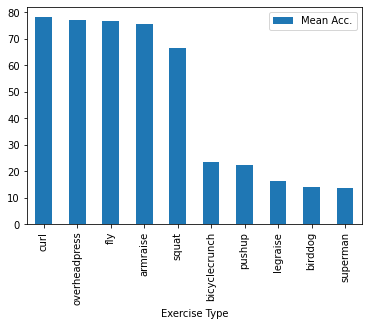

In [26]:
# plot accuracy per exercise type

#xlabels = list(df1_folders['ex_name'])
#print(xlabels)

sorted_results_per_folder_1_0_vis_all_df.plot(x='Exercise Type', y="Mean Acc.", kind="bar")
plt.show()

# EXP1b: Lightning, PDJ@0.2, v=None(all keypoints)

In [27]:
results_global_mean_0_2_vis_all, results_per_folder_0_2_vis_all, results_per_vid_0_2_vis_all = video_folder_predictions(actual_directory, 'pdj', 0.2, visibility=None)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 0.016160310277957335
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 0.027233115468409584
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
<class '

# EXP2: Lightning, PDJ@1.0, v=2 (in frame & unoccluded)

In [28]:
results_global_mean_1_0_vis_2, results_per_folder_1_0_vis_2, results_per_vid_1_0_vis_2 = video_folder_predictions(actual_directory, 'pdj', 1, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 93.69280410947077
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000002
VIDEO

In [29]:
print( 'global mean: ', results_global_mean_1_0_vis_2 )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_1_0_vis_2_df = pd.DataFrame(results_per_vid_1_0_vis_2)
print( 'DF1: ' )
display( results_per_vid_1_0_vis_2_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
df2_videos = pd.DataFrame(results_per_folder_1_0_vis_2)
results_per_folder_1_0_vis_2_df = pd.DataFrame({ 'Exercise Name' : df2_videos[0], 'Avg. Accuracy' : df2_videos[1] })
results_per_folder_1_0_vis_2_df = results_per_folder_1_0_vis_2_df.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2: ' )
display( results_per_folder_1_0_vis_2_df )

global mean:  53.72356339153261

DF1: 


0       1           2
0  curl  000000  100.000000
1  curl  000001   93.692804
2  curl  000002   91.957065
3  curl  000003  100.000000
4  curl  000004   91.922614


DF2: 


Exercise Name  Avg. Accuracy
0           curl      89.071589
7            fly      88.027988
3  overheadpress      87.856877
1       armraise      85.930152
9          squat      76.774063
8  bicyclecrunch      30.275335
6         pushup      26.707824
2       legraise      22.430393
5       superman      16.523015
4        birddog      13.638398

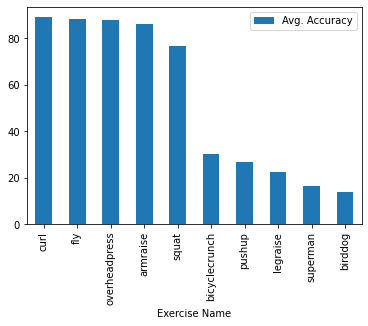

In [30]:
results_per_folder_1_0_vis_2_df.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

# EXP2b: Lightning, PDJ@0.2, v=2 (in frame & unoccluded)

In [31]:
results_global_mean_0_2_vis_2, results_per_folder_0_2_vis_2, results_per_vid_0_2_vis_2 = video_folder_predictions(actual_directory, 'pdj', 0.2, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 0.019623233908948195
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 0.03561253561253561
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 's

# NOT POSSIBLE RIGHT NOW EXP3: Lightning, PDJ@1.0, v='a2o' (ALL visible ONLY)

In [23]:
results_global_mean_1_0_vis_a2o, results_per_folder_1_0_vis_a2o, results_per_vid_1_0_vis_a2o = video_folder_predictions(actual_directory, 'pdj', 1, 'a2o')

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 0.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 0.0
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: curl 

In [24]:
print( 'global mean: ', results_global_mean_1_0_vis_a2o )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_1_0_vis_a2o_df = pd.DataFrame(results_per_vid_1_0_vis_a2o)
print( 'DF1: ' )
display( results_per_vid_1_0_vis_a2o_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
results_per_folder_1_0_vis_a2o_df = pd.DataFrame({ 'Exercise Name' : df2_videos[0].unique(), 'Avg. Accuracy' : results_per_folder_1_0_vis_a2o })
results_per_folder_1_0_vis_a2o_df = results_per_folder_1_0_vis_a2o_df.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2: ' )
display( results_per_folder_1_0_vis_a2o_df )

global mean:  0.0

DF1: 


0       1    2
0  curl  000000  0.0
1  curl  000001  0.0
2  curl  000002  0.0
3  curl  000003  0.0
4  curl  000004  0.0


DF2: 


Exercise Name         Avg. Accuracy
5       superman       [superman, 0.0]
9          squat          [squat, 0.0]
6         pushup         [pushup, 0.0]
3  overheadpress  [overheadpress, 0.0]
2       legraise       [legraise, 0.0]
7            fly            [fly, 0.0]
0           curl           [curl, 0.0]
4        birddog        [birddog, 0.0]
8  bicyclecrunch  [bicyclecrunch, 0.0]
1       armraise       [armraise, 0.0]

In [25]:
results_per_folder_1_0_vis_a2o_df.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

TypeError: no numeric data to plot

# EXP4: Lightning, PCK@1.0, vis=None (ALL keypoints)

In [32]:
results_global_mean_pck_1_0_vis_all, results_per_folder_pck_1_0_vis_all, results_per_vid_pck_1_0_vis_all = video_folder_predictions(actual_directory, 'pck', 1)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 94.11764705882352
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 88.23529411764704
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
<class 'str'>


In [33]:
print( 'global mean: ', results_global_mean_pck_1_0_vis_all )

display( pd.DataFrame(results_per_folder_pck_1_0_vis_all) )

global mean:  81.26822455207949


0          1
0           curl  94.281404
1       armraise  93.304523
2       legraise  65.421229
3  overheadpress  95.277051
4        birddog  77.782572
5       superman  71.260347
6         pushup  67.740017
7            fly  94.324791
8  bicyclecrunch  62.527047
9          squat  90.763264

In [34]:
print( 'global mean: ', results_global_mean_pck_1_0_vis_all )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
df3_videos = pd.DataFrame(results_per_vid_pck_1_0_vis_all)
print( 'DF1, per vid: ' )
display( df3_videos.head() )
print()
# make new dataframe with unique ex_names and accs per folder
df3_videos = pd.DataFrame( results_per_folder_pck_1_0_vis_all )
results_per_folder_pck_1_0_vis_all = pd.DataFrame({ 'Exercise Name' : df3_videos[0], 'Avg. Accuracy' : df3_videos[1] })
df3_folders = results_per_folder_pck_1_0_vis_all.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2, per ex type: ' )
display( df3_folders )

global mean:  81.26822455207949

DF1, per vid: 


0       1           2
0  curl  000000   94.117647
1  curl  000001   88.235294
2  curl  000002   88.235294
3  curl  000003  100.000000
4  curl  000004  100.000000


DF2, per ex type: 


Exercise Name  Avg. Accuracy
3  overheadpress      95.277051
7            fly      94.324791
0           curl      94.281404
1       armraise      93.304523
9          squat      90.763264
4        birddog      77.782572
5       superman      71.260347
6         pushup      67.740017
2       legraise      65.421229
8  bicyclecrunch      62.527047

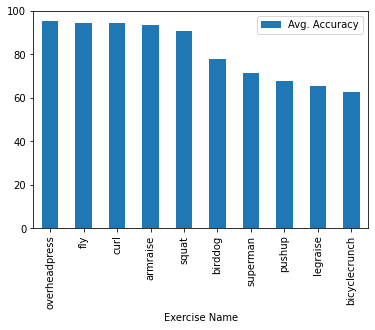

In [35]:
df3_folders.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

# EXP4b: Lightning, PCK@0.2, vis=None (ALL keypoints)

In [36]:
results_global_mean_pck_0_2_vis_all, results_per_folder_pck_0_2_vis_all, results_per_vid_pck_0_2_vis_all = video_folder_predictions(actual_directory, 'pck', 0.2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 51.40594699418228
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 33.85076252723312
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
<class 'str'>


# EXP5: Lightning, PCK@1.0, vis=2 (in frame & unoccluded)

In [37]:
results_global_mean_pck_1_0_vis_2, results_per_folder_pck_1_0_vis_2, results_per_vid_pck_1_0_vis_2 = video_folder_predictions(actual_directory, 'pck', 1, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

In [38]:
print( 'global mean: ', results_global_mean_pck_1_0_vis_2 )
print()

# create dataframe [1] for each video and [2] for each folder.

# create DF of video accuracies TO get unique ex_names
results_per_vid_pck_1_0_vis_2_df = pd.DataFrame(results_per_vid_pck_1_0_vis_2)
print( 'DF1, per vid: ' )
display( results_per_vid_pck_1_0_vis_2_df.head() )
print()
# make new dataframe with unique ex_names and accs per folder
df4_videos = pd.DataFrame( results_per_folder_pck_1_0_vis_2 )
results_per_folder_pck_1_0_vis_2_df = pd.DataFrame({ 'Exercise Name' : df4_videos[0], 'Avg. Accuracy' : df4_videos[1] })
results_per_folder_pck_1_0_vis_2_df = results_per_folder_pck_1_0_vis_2_df.sort_values(by='Avg. Accuracy', ascending=False)
print( 'DF2, per ex type: ' )
display( results_per_folder_pck_1_0_vis_2_df )

global mean:  89.68255997568328

DF1, per vid: 


0       1      2
0  curl  000000  100.0
1  curl  000001  100.0
2  curl  000002  100.0
3  curl  000003  100.0
4  curl  000004  100.0


DF2, per ex type: 


Exercise Name  Avg. Accuracy
1       armraise      99.961283
7            fly      99.841940
3  overheadpress      99.303540
9          squat      99.242081
0           curl      98.864675
4        birddog      88.107477
5       superman      81.496054
6         pushup      78.719358
2       legraise      77.649688
8  bicyclecrunch      73.639503

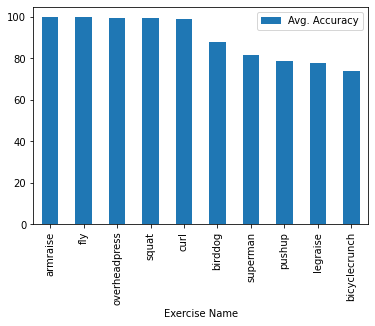

In [39]:
results_per_folder_pck_1_0_vis_2_df.plot(x='Exercise Name', y="Avg. Accuracy", kind="bar")
plt.show()

# EXP5b:Lightning, PCK@0.2, vis=2 (in frame & unoccluded)

In [40]:
results_global_mean_pck_0_2_vis_2, results_per_folder_pck_0_2_vis_2, results_per_vid_pck_0_2_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.2, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 58.65837459244052
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 44.74763662263662
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>


# EXP5c:Lightning, PCK@0.3, vis=2 (in frame & unoccluded)

In [58]:
results_global_mean_pck_0_3_vis_2, results_per_folder_pck_0_3_vis_2, results_per_vid_pck_0_3_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.3, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 91.62107182940515
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
<class 'str'>
000002
VIDEO

# EXP5d:Lightning, PCK@0.4, vis=2 (in frame & unoccluded)

In [59]:
results_global_mean_pck_0_4_vis_2, results_per_folder_pck_0_4_vis_2, results_per_vid_pck_0_4_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.4, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 99.88668738668738
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
<class 'str'>
000002
VIDEO

# EXP5e:Lightning, PCK@0.5, vis=2 (in frame & unoccluded)

In [60]:
results_global_mean_pck_0_5_vis_2, results_per_folder_pck_0_5_vis_2, results_per_vid_pck_0_5_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.5, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5f:Lightning, PCK@0.6, vis=2 (in frame & unoccluded)

In [61]:
results_global_mean_pck_0_6_vis_2, results_per_folder_pck_0_6_vis_2, results_per_vid_pck_0_6_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.6, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5g:Lightning, PCK@0.7, vis=2 (in frame & unoccluded)

In [ ]:
results_global_mean_pck_0_7_vis_2, results_per_folder_pck_0_7_vis_2, results_per_vid_pck_0_7_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.7, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5h:Lightning, PCK@0.8, vis=2 (in frame & unoccluded)

In [63]:
results_global_mean_pck_0_8_vis_2, results_per_folder_pck_0_8_vis_2, results_per_vid_pck_0_8_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.8, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5i:Lightning, PCK@0.9, vis=2 (in frame & unoccluded)

In [64]:
results_global_mean_pck_0_9_vis_2, results_per_folder_pck_0_9_vis_2, results_per_vid_pck_0_9_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.9, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 100.0
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 'str'>
000002
VIDEO COMPLETE: c

# EXP5j:Lightning, PCK@0.1, vis=2 (in frame & unoccluded)

In [65]:
results_global_mean_pck_0_1_vis_2, results_per_folder_pck_0_1_vis_2, results_per_vid_pck_0_1_vis_2 = video_folder_predictions(actual_directory, 'pck', 0.1, 2)

['InfinityAI Data/infinityai_fitness_basic_curl_v1.0', 'InfinityAI Data/infinityai_fitness_basic_armraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_legraise_v1.0', 'InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0', 'InfinityAI Data/infinityai_fitness_basic_birddog_v1.0', 'InfinityAI Data/infinityai_fitness_basic_superman_v1.0', 'InfinityAI Data/infinityai_fitness_basic_pushup_v1.0', 'InfinityAI Data/infinityai_fitness_basic_fly_v1.0', 'InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0', 'InfinityAI Data/infinityai_fitness_basic_squat_v1.0']
curl
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
<class 'str'>
000000
VIDEO COMPLETE: curl 000000 - vid_acc: 0.019623233908948195
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
<class 'str'>
000001
VIDEO COMPLETE: curl 000001 - vid_acc: 0.37447120780454113
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
<class 's

# Create DF for each video

In [202]:
# with DF containing accuracy per video (unique to each experiment)
df_per_video = pd.DataFrame(   )

# create DF containing metadata per video in following folders:


curl_folder = "InfinityAI Data/infinityai_fitness_basic_curl_v1.0"
armraise_folder = "InfinityAI Data/infinityai_fitness_basic_armraise_v1.0"
legraise_folder = "InfinityAI Data/infinityai_fitness_basic_legraise_v1.0"
overheadpress_folder = "InfinityAI Data/infinityai_fitness_basic_overheadpress_v1.0"
birddog_folder = "InfinityAI Data/infinityai_fitness_basic_birddog_v1.0"
superman_folder = "InfinityAI Data/infinityai_fitness_basic_superman_v1.0"
pushup_folder = "InfinityAI Data/infinityai_fitness_basic_pushup_v1.0"
basic_fly_folder = "InfinityAI Data/infinityai_fitness_basic_fly_v1.0"
bicyclecrunch_folder = "InfinityAI Data/infinityai_fitness_basic_bicyclecrunch_v1.0"
squat_folder = "InfinityAI Data/infinityai_fitness_basic_squat_v1.0"

sub_folders = [ curl_folder, armraise_folder, legraise_folder, overheadpress_folder, birddog_folder, 
           superman_folder, pushup_folder, basic_fly_folder, bicyclecrunch_folder, squat_folder ]

In [237]:
# metadata per video

def meta_per_video(folder):
    
    metadata = []
    
    for sub_folders in folder:
    
        # iterate over annotation jsons for each video and extract labels
        json_paths = sorted(glob.glob(os.path.join(sub_folders, "*.json")))

        for json_path in json_paths:

            ex_name = json_path.split("/")[-2]
            ex_name = ex_name.split("_")[-2]

            ex_num = json_path.split(".")[-2]
            ex_num = ex_num.split("/")[-1]

            coco = COCO(json_path)
            percent_in_fov = []
            percent_occlusion = []
            for ann in coco.anns.values():
                if coco.cats[ann["category_id"]]["name"] != "person":
                    # skip any non-person annotations (e.g. for dumbbells)
                    continue
                percent_in_fov.append(ann["percent_in_fov"])
                percent_occlusion.append(ann["percent_occlusion"])
            avg_percent_in_fov = np.mean(percent_in_fov)  # average across frames
            avg_percent_occlusion = np.mean(percent_occlusion)  # average across frames
            metadata.append({
                            "ex_name": ex_name,
                            "video_number": coco.dataset["info"]["video_number"],
                            "avg_percent_in_fov": avg_percent_in_fov,
                            "avg_percent_occlusion": avg_percent_occlusion,
                            "camera_height": coco.dataset["info"]["camera_height"],
                            "camera_pitch": coco.dataset["info"]["camera_pitch"],
                            })               
    
    metadata_df = pd.DataFrame(metadata)

    return metadata_df


metadata_full = meta_per_video(sub_folders)
clear_output()
print('Done')

Done


In [238]:
#pprint(metadata_full)

display(metadata_full)

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0             curl             0           95.901492               2.642545   
1             curl             1          100.000000              11.840264   
2             curl             2          100.000000               2.664757   
3             curl             3          100.000000               1.992999   
4             curl             4           99.744104               4.424402   
5             curl             5           94.199886               2.550902   
6             curl             6           98.968708               1.970541   
7             curl             7          100.000000               3.462163   
8             curl             8           89.587804               2.370963   
9             curl             9          100.000000              16.948765   
10            curl            10          100.000000               2.644054   
11            curl            11           93.759050               2.454222   
12            curl            12          100.000000              96.489086   
13            curl            13           94.715598               3.323321   
14            curl            14          100.000000               2.383347   
15            curl            15          100.000000               1.926323   
16            curl            16          100.000000               3.562261   
17            curl            17          100.000000               3.334287   
18            curl            18           98.252418               2.712220   
19            curl            19           98.231419               4.572685   
20            curl            20           95.100901               2.689407   
21            curl            21          100.000000               2.793964   
22            curl            22          100.000000               2.232001   
23            curl            23          100.000000               3.414503   
24            curl            24           96.190931               3.599022   
25            curl            25          100.000000               3.778224   
26            curl            26          100.000000               3.772998   
27            curl            27          100.000000               3.273214   
28            curl            28          100.000000              59.947629   
29            curl            29          100.000000               3.025386   
30            curl            30           97.890002               3.764236   
31            curl            31          100.000000               2.852666   
32            curl            32          100.000000               3.637314   
33            curl            33          100.000000               3.582896   
34            curl            34          100.000000               3.737622   
35            curl            35          100.000000               4.276199   
36            curl            36          100.000000               3.168427   
37            curl            37           94.959935               1.954590   
38            curl            38           93.999750               2.591131   
39            curl            39           93.627597               3.202952   
40            curl            40          100.000000               2.930444   
41            curl            41           98.878470               3.370989   
42            curl            42          100.000000               1.736757   
43            curl            43           96.710136               2.434051   
44            curl            44           99.486184               2.064449   
45            curl            45           95.807117               2.493004   
46            curl            46          100.000000               3.286782   
47            curl            47          100.000000               1.953673   
48            curl            48          100.000000               4.724502   
49            curl            49          100.000000         

In [229]:
### NOW USE THIS DATAFRAME TO CALCULATE ACCUARACY CONSIDERING ONLY VIDEOS WITH 100% FOV AND <X% OCCLUSION
### DETERMINE X% OCCLUSION BY PLOTTING IT AND SELECTING

# DF Append w. Accuracies

In [230]:
# simple add column with list of results as new column - visually inspect column for errors

#metadata_full["Exp_1"] = pd.DataFrame(results_per_vid_1_0_vis_all)[2]
#metadata_full["Exp_1b"] = pd.DataFrame(results_per_vid_0_2_vis_all)[2]
#metadata_full["Exp_2"] = pd.DataFrame(results_per_vid_1_0_vis_2)[2]
#metadata_full["Exp_2b"] = pd.DataFrame(results_per_vid_0_2_vis_2)[2]
#metadata_full["Exp_4"] = pd.DataFrame(results_per_vid_pck_1_0_vis_all)[2]
#metadata_full["Exp_4b"] = pd.DataFrame(results_per_vid_pck_0_2_vis_all)[2]



In [239]:
metadata_full["0.1"] = pd.DataFrame(results_per_vid_pck_0_1_vis_2)[2]
metadata_full["0.2"] = pd.DataFrame(results_per_vid_pck_0_2_vis_2)[2]
metadata_full["0.3"] = pd.DataFrame(results_per_vid_pck_0_3_vis_2)[2]
metadata_full["0.4"] = pd.DataFrame(results_per_vid_pck_0_4_vis_2)[2]
metadata_full["0.5"] = pd.DataFrame(results_per_vid_pck_0_5_vis_2)[2]
metadata_full["0.6"] = pd.DataFrame(results_per_vid_pck_0_6_vis_2)[2]
metadata_full["0.7"] = pd.DataFrame(results_per_vid_pck_0_7_vis_2)[2]
metadata_full["0.8"] = pd.DataFrame(results_per_vid_pck_0_8_vis_2)[2]
metadata_full["0.9"] = pd.DataFrame(results_per_vid_pck_0_9_vis_2)[2]
metadata_full["1.0"] = pd.DataFrame(results_per_vid_pck_1_0_vis_2)[2]

In [240]:
pd.set_option('display.max_rows', None)
display(metadata_full[:])

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0             curl             0           95.901492               2.642545   
1             curl             1          100.000000              11.840264   
2             curl             2          100.000000               2.664757   
3             curl             3          100.000000               1.992999   
4             curl             4           99.744104               4.424402   
5             curl             5           94.199886               2.550902   
6             curl             6           98.968708               1.970541   
7             curl             7          100.000000               3.462163   
8             curl             8           89.587804               2.370963   
9             curl             9          100.000000              16.948765   
10            curl            10          100.000000               2.644054   
11            curl            11           93.759050               2.454222   
12            curl            12          100.000000              96.489086   
13            curl            13           94.715598               3.323321   
14            curl            14          100.000000               2.383347   
15            curl            15          100.000000               1.926323   
16            curl            16          100.000000               3.562261   
17            curl            17          100.000000               3.334287   
18            curl            18           98.252418               2.712220   
19            curl            19           98.231419               4.572685   
20            curl            20           95.100901               2.689407   
21            curl            21          100.000000               2.793964   
22            curl            22          100.000000               2.232001   
23            curl            23          100.000000               3.414503   
24            curl            24           96.190931               3.599022   
25            curl            25          100.000000               3.778224   
26            curl            26          100.000000               3.772998   
27            curl            27          100.000000               3.273214   
28            curl            28          100.000000              59.947629   
29            curl            29          100.000000               3.025386   
30            curl            30           97.890002               3.764236   
31            curl            31          100.000000               2.852666   
32            curl            32          100.000000               3.637314   
33            curl            33          100.000000               3.582896   
34            curl            34          100.000000               3.737622   
35            curl            35          100.000000               4.276199   
36            curl            36          100.000000               3.168427   
37            curl            37           94.959935               1.954590   
38            curl            38           93.999750               2.591131   
39            curl            39           93.627597               3.202952   
40            curl            40          100.000000               2.930444   
41            curl            41           98.878470               3.370989   
42            curl            42          100.000000               1.736757   
43            curl            43           96.710136               2.434051   
44            curl            44           99.486184               2.064449   
45            curl            45           95.807117               2.493004   
46            curl            46          100.000000               3.286782   
47            curl            47          100.000000               1.953673   
48            curl            48          100.000000               4.724502   
49            curl            49          100.000000         

In [241]:
# save DF to CSV

metadata_full.to_csv('thunder_data_APV.csv', index=False)

In [3]:
# import CSV and test
df = pd.read_csv('thunder_data_APV.csv')
display(df[:3])

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0    curl             0           95.901492               2.642545   
1    curl             1          100.000000              11.840264   
2    curl             2          100.000000               2.664757   

   camera_height  camera_pitch       0.1        0.2         0.3         0.4  \
0       1.477322     87.239855  0.019623  58.658375  100.000000  100.000000   
1       0.847416     95.694468  0.374471  44.747637   91.621072   99.886687   
2       1.790054     84.172874  0.032600  25.972980   89.074442   95.200077   

          0.5         0.6    0.7    0.8    0.9    1.0  
0  100.000000  100.000000  100.0  100.0  100.0  100.0  
1  100.000000  100.000000  100.0  100.0  100.0  100.0  
2   98.779745   99.965072  100.0  100.0  100.0  100.0

array([[<AxesSubplot:title={'center':'avg_percent_in_fov'}>]],
      dtype=object)

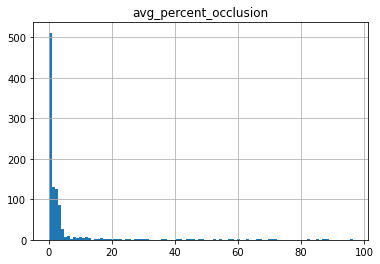

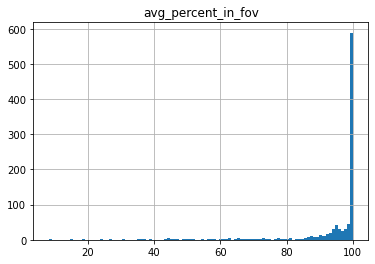

In [4]:
# plot fov to get a feel for best cutoff

df.hist("avg_percent_occlusion", bins=100)
df.hist("avg_percent_in_fov", bins=100)

In [6]:
# create new DF with rows that meet chosen criteria [FOV = 100%, OCC <2%],
# this will then be used to calc new mean and plot for chosen criteria

df_5 = df[df["avg_percent_in_fov"] > 95]
df_5 = df_5[df_5["avg_percent_occlusion"] < 5]

print(df_5.shape)

display(df_5)

(633, 16)


ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0      curl             0           95.901492               2.642545   
2      curl             2          100.000000               2.664757   
3      curl             3          100.000000               1.992999   
4      curl             4           99.744104               4.424402   
6      curl             6           98.968708               1.970541   
..      ...           ...                 ...                    ...   
994   squat            95           98.400702               0.000000   
995   squat            96           97.998026               0.009473   
996   squat            97          100.000000               2.675084   
997   squat            98          100.000000               0.093388   
998   squat            99           99.154815               0.025417   

     camera_height  camera_pitch        0.1        0.2         0.3  \
0         1.477322     87.239855   0.019623  58.658375  100.000000   
2         1.790054     84.172874   0.032600  25.972980   89.074442   
3         1.917482     79.964897   0.000000  72.901450  100.000000   
4         1.481914     85.833956  15.351093  52.022256   91.445895   
6         1.267692     91.662928   1.416588  77.157943   98.649873   
..             ...           ...        ...        ...         ...   
994       1.781202     81.234117   0.000000  34.908593   91.744937   
995       0.974657     93.996182   0.000000  25.413534   92.096909   
996       0.927425     93.705865   0.030656   3.780912   62.957286   
997       1.841079     80.624496   3.818304  61.899960   99.394438   
998       1.871776     79.684860   0.245700  30.662221   86.731827   

            0.4         0.5         0.6    0.7    0.8    0.9    1.0  
0    100.000000  100.000000  100.000000  100.0  100.0  100.0  100.0  
2     95.200077   98.779745   99.965072  100.0  100.0  100.0  100.0  
3    100.000000  100.000000  100.000000  100.0  100.0  100.0  100.0  
4     99.663057  100.000000  100.000000  100.0  100.0  100.0  100.0  
6    100.000000  100.000000  100.000000  100.0  100.0  100.0  100.0  
..          ...         ...         ...    ...    ...    ...    ...  
994   97.852217  100.000000  100.000000  100.0  100.0  100.0  100.0  
995  100.000000  100.000000  100.000000  100.0  100.0  100.0  100.0  
996   89.854816   96.991385   99.270543  100.0  100.0  100.0  100.0  
997   99.919743  100.000000  100.000000  100.0  100.0  100.0  100.0  
998   99.180999  100.000000  100.000000  100.0  100.0  100.0  100.0  

[633 rows x 16 columns]

In [7]:
df_5_clean = df_5.drop( columns=['avg_percent_in_fov', 'avg_percent_occlusion', 'camera_height', 'camera_pitch'] )
display(df_5_clean.head())

ex_name  video_number        0.1        0.2         0.3         0.4  \
0    curl             0   0.019623  58.658375  100.000000  100.000000   
2    curl             2   0.032600  25.972980   89.074442   95.200077   
3    curl             3   0.000000  72.901450  100.000000  100.000000   
4    curl             4  15.351093  52.022256   91.445895   99.663057   
6    curl             6   1.416588  77.157943   98.649873  100.000000   

          0.5         0.6    0.7    0.8    0.9    1.0  
0  100.000000  100.000000  100.0  100.0  100.0  100.0  
2   98.779745   99.965072  100.0  100.0  100.0  100.0  
3  100.000000  100.000000  100.0  100.0  100.0  100.0  
4  100.000000  100.000000  100.0  100.0  100.0  100.0  
6  100.000000  100.000000  100.0  100.0  100.0  100.0

In [8]:
df_5_plot = df_5_clean.drop(columns='video_number')
display(df_5_plot.head())

ex_name        0.1        0.2         0.3         0.4         0.5  \
0    curl   0.019623  58.658375  100.000000  100.000000  100.000000   
2    curl   0.032600  25.972980   89.074442   95.200077   98.779745   
3    curl   0.000000  72.901450  100.000000  100.000000  100.000000   
4    curl  15.351093  52.022256   91.445895   99.663057  100.000000   
6    curl   1.416588  77.157943   98.649873  100.000000  100.000000   

          0.6    0.7    0.8    0.9    1.0  
0  100.000000  100.0  100.0  100.0  100.0  
2   99.965072  100.0  100.0  100.0  100.0  
3  100.000000  100.0  100.0  100.0  100.0  
4  100.000000  100.0  100.0  100.0  100.0  
6  100.000000  100.0  100.0  100.0  100.0

In [9]:
#ex_names = df_5_plot['ex_name'].unique()

df_5_plot = df_5_plot.groupby('ex_name').mean().round(2)
display(df_5_plot)

0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
armraise       2.10  39.51  82.86  94.27  98.20  99.48  99.75   99.83   99.91   
bicyclecrunch  1.05   4.68  12.28  24.84  38.28  50.30  59.49   66.23   71.45   
birddog        0.31   1.21   3.94  14.55  33.36  51.06  66.40   76.45   84.04   
curl           3.62  51.43  90.02  97.14  98.98  99.62  99.94  100.00  100.00   
fly            4.95  54.02  87.50  96.39  98.98  99.77  99.96  100.00  100.00   
legraise       1.20   6.16  18.10  32.93  45.61  55.17  62.29   68.60   74.35   
overheadpress  9.87  60.77  90.15  97.19  99.13  99.59  99.75   99.86   99.94   
pushup         0.21   1.23   4.74  12.73  25.60  41.40  55.15   65.11   71.25   
squat          1.16  27.72  69.15  88.66  95.20  97.71  98.64   99.10   99.26   
superman       1.43   6.88  20.97  38.25  49.46  58.83  67.08   73.83   78.17   

                  1.0  
ex_name                
armraise        99.95  
bicyclecrunch   75.39  
birddog         88.16  
curl           100.00  
fly            100.00  
legraise        78.77  
overheadpress   99.98  
pushup          75.35  
squat           99.32  
superman        82.30

In [10]:
# save DF to CSV

df_5_plot.to_csv('thunder_data_per_ex.csv', index=True)

In [11]:
# import CSV and test
df_5_plot = pd.read_csv('thunder_data_per_ex.csv', index_col=0)
display(df[:3])

ex_name  video_number  avg_percent_in_fov  avg_percent_occlusion  \
0    curl             0           95.901492               2.642545   
1    curl             1          100.000000              11.840264   
2    curl             2          100.000000               2.664757   

   camera_height  camera_pitch       0.1        0.2         0.3         0.4  \
0       1.477322     87.239855  0.019623  58.658375  100.000000  100.000000   
1       0.847416     95.694468  0.374471  44.747637   91.621072   99.886687   
2       1.790054     84.172874  0.032600  25.972980   89.074442   95.200077   

          0.5         0.6    0.7    0.8    0.9    1.0  
0  100.000000  100.000000  100.0  100.0  100.0  100.0  
1  100.000000  100.000000  100.0  100.0  100.0  100.0  
2   98.779745   99.965072  100.0  100.0  100.0  100.0

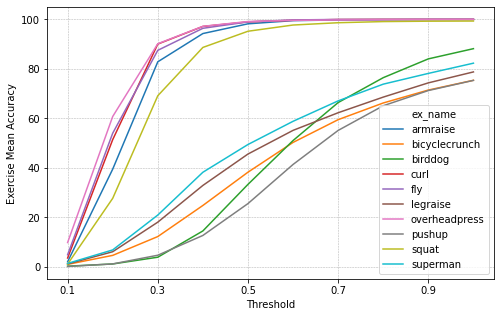

In [12]:
ax = df_5_plot.T.plot(figsize=(8,5))
ax.set_xlabel('Threshold')
ax.set_ylabel('Exercise Mean Accuracy')
ax.grid(linestyle='--', linewidth=0.5)

# try seaborn first, might resolve the followign automatically
# move legend
# include all x axis labels, and potential verical dashed lines
# plot histogram of average of each exercise to clearly show which exercises

In [33]:
# add column of means
df_5_plot['mean'] = list(df_5_plot.mean(axis=1))
df_5_plot['std'] = list(df_5_plot.std(axis=1))
display(df_5_plot)

0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
pushup         0.21   1.23   4.74  12.73  25.60  41.40  55.15   65.11   71.25   
bicyclecrunch  1.05   4.68  12.28  24.84  38.28  50.30  59.49   66.23   71.45   
birddog        0.31   1.21   3.94  14.55  33.36  51.06  66.40   76.45   84.04   
legraise       1.20   6.16  18.10  32.93  45.61  55.17  62.29   68.60   74.35   
superman       1.43   6.88  20.97  38.25  49.46  58.83  67.08   73.83   78.17   
squat          1.16  27.72  69.15  88.66  95.20  97.71  98.64   99.10   99.26   
armraise       2.10  39.51  82.86  94.27  98.20  99.48  99.75   99.83   99.91   
curl           3.62  51.43  90.02  97.14  98.98  99.62  99.94  100.00  100.00   
fly            4.95  54.02  87.50  96.39  98.98  99.77  99.96  100.00  100.00   
overheadpress  9.87  60.77  90.15  97.19  99.13  99.59  99.75   99.86   99.94   

                  1.0    mean        std  
ex_name                                   
pushup          75.35  35.277  28.540760  
bicyclecrunch   75.39  40.399  26.794986  
birddog         88.16  41.948  33.824432  
legraise        78.77  44.318  26.931709  
superman        82.30  47.720  28.145858  
squat           99.32  77.592  33.293890  
armraise        99.95  81.586  31.910689  
curl           100.00  84.075  30.366201  
fly            100.00  84.157  29.680016  
overheadpress   99.98  85.623  27.751321

Text(0.5, 0, 'Exercise Mean Accuracy')

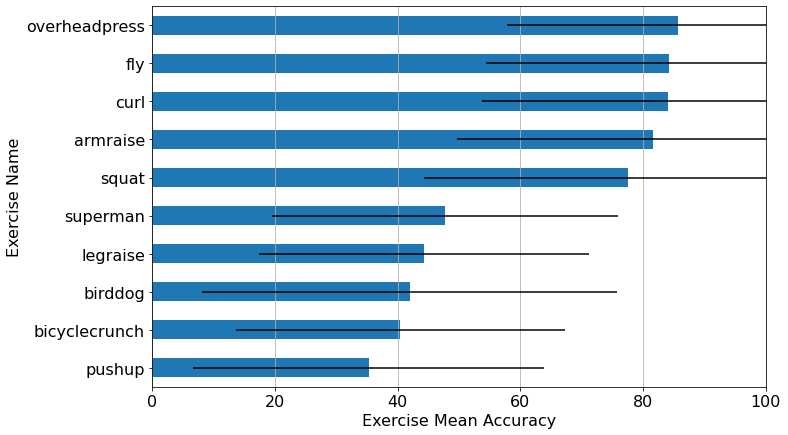

In [34]:
y_err = list(df_5_plot["std"])

ax2 = df_5_plot['mean'].sort_values().plot.barh(figsize=(11,7), xerr=y_err, xlim=(0,100), fontsize=16)
ax2.grid(axis='x')
ax2.set_ylabel('Exercise Name', fontdict={'fontsize':16})
ax2.set_xlabel('Exercise Mean Accuracy', fontdict={'fontsize':16})
#ax2.title('Mean Accuracy Per Exercise for All Thresholds')

In [46]:
full_mean = df_5_plot['mean'].mean()
print(full_mean)

62.26950000000001


In [47]:
hoz_err = []

for thresh in df_hoz.columns:
    print(str(thresh)+" mean: ", round(df_hoz[thresh].mean(), 2))
    print(str(thresh)+" std: ", round(df_hoz[thresh].std(), 2))
    hoz_err.append(df_hoz[thresh].std())

0.1 mean:  0.84
0.1 std:  0.55
0.2 mean:  4.03
0.2 std:  2.69
0.3 mean:  12.01
0.3 std:  7.67
0.4 mean:  24.66
0.4 std:  11.15
0.5 mean:  38.46
0.5 std:  9.53
0.6 mean:  51.35
0.6 std:  6.53
0.7 mean:  62.08
0.7 std:  4.96
0.8 mean:  70.04
0.8 std:  4.91
0.9 mean:  75.85
0.9 std:  5.37
1.0 mean:  79.99
1.0 std:  5.39
mean mean:  41.93
mean std:  4.63
std mean:  28.85
std std:  2.88


In [48]:
df_5_plot = df_5_plot.sort_values('mean')
display(df_5_plot)

0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
pushup         0.21   1.23   4.74  12.73  25.60  41.40  55.15   65.11   71.25   
bicyclecrunch  1.05   4.68  12.28  24.84  38.28  50.30  59.49   66.23   71.45   
birddog        0.31   1.21   3.94  14.55  33.36  51.06  66.40   76.45   84.04   
legraise       1.20   6.16  18.10  32.93  45.61  55.17  62.29   68.60   74.35   
superman       1.43   6.88  20.97  38.25  49.46  58.83  67.08   73.83   78.17   
squat          1.16  27.72  69.15  88.66  95.20  97.71  98.64   99.10   99.26   
armraise       2.10  39.51  82.86  94.27  98.20  99.48  99.75   99.83   99.91   
curl           3.62  51.43  90.02  97.14  98.98  99.62  99.94  100.00  100.00   
fly            4.95  54.02  87.50  96.39  98.98  99.77  99.96  100.00  100.00   
overheadpress  9.87  60.77  90.15  97.19  99.13  99.59  99.75   99.86   99.94   

                  1.0    mean        std  
ex_name                                   
pushup          75.35  35.277  28.540760  
bicyclecrunch   75.39  40.399  26.794986  
birddog         88.16  41.948  33.824432  
legraise        78.77  44.318  26.931709  
superman        82.30  47.720  28.145858  
squat           99.32  77.592  33.293890  
armraise        99.95  81.586  31.910689  
curl           100.00  84.075  30.366201  
fly            100.00  84.157  29.680016  
overheadpress   99.98  85.623  27.751321

In [49]:
df_hoz = df_5_plot['pushup':'superman']

hoz_mean = df_hoz['mean'].mean()
print('hoz mean: ', hoz_mean)

hoz_thresh_mean = []

for thresh in df_hoz.columns:
    hoz_thresh_mean.append(round(df_hoz[thresh].mean(), 2))
    
print(hoz_thresh_mean)

#df_hoz.loc('mean') = hoz_thresh_mean

display(df_hoz)

hoz mean:  41.932399999999994
[0.84, 4.03, 12.01, 24.66, 38.46, 51.35, 62.08, 70.04, 75.85, 79.99, 41.93, 28.85]


0.1   0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9  \
ex_name                                                                      
pushup         0.21  1.23   4.74  12.73  25.60  41.40  55.15  65.11  71.25   
bicyclecrunch  1.05  4.68  12.28  24.84  38.28  50.30  59.49  66.23  71.45   
birddog        0.31  1.21   3.94  14.55  33.36  51.06  66.40  76.45  84.04   
legraise       1.20  6.16  18.10  32.93  45.61  55.17  62.29  68.60  74.35   
superman       1.43  6.88  20.97  38.25  49.46  58.83  67.08  73.83  78.17   

                 1.0    mean        std  
ex_name                                  
pushup         75.35  35.277  28.540760  
bicyclecrunch  75.39  40.399  26.794986  
birddog        88.16  41.948  33.824432  
legraise       78.77  44.318  26.931709  
superman       82.30  47.720  28.145858

In [50]:
vert_err = []

for thresh in df_vert.columns:
    print(str(thresh)+" mean: ", round(df_vert[thresh].mean(), 2))
    print(str(thresh)+" std: ", round(df_vert[thresh].std(), 2))
    vert_err.append(df_vert[thresh].std())

0.1 mean:  4.34
0.1 std:  3.41
0.2 mean:  46.69
0.2 std:  13.09
0.3 mean:  83.94
0.3 std:  8.78
0.4 mean:  94.73
0.4 std:  3.59
0.5 mean:  98.1
0.5 std:  1.66
0.6 mean:  99.23
0.6 std:  0.86
0.7 mean:  99.61
0.7 std:  0.55
0.8 mean:  99.76
0.8 std:  0.38
0.9 mean:  99.82
0.9 std:  0.32
1.0 mean:  99.85
1.0 std:  0.3
mean mean:  82.61
mean std:  3.16
std mean:  30.6
std std:  2.12


In [51]:
df_vert = df_5_plot['squat':]
vert_mean = df_vert['mean'].mean()
print('vert mean: ', vert_mean)

vert_thresh_mean = []

for thresh in df_vert.columns:
    vert_thresh_mean.append(round(df_vert[thresh].mean(), 2))
    
print(vert_thresh_mean)

display(df_vert)

vert mean:  82.60659999999999
[4.34, 46.69, 83.94, 94.73, 98.1, 99.23, 99.61, 99.76, 99.82, 99.85, 82.61, 30.6]


0.1    0.2    0.3    0.4    0.5    0.6    0.7     0.8     0.9  \
ex_name                                                                         
squat          1.16  27.72  69.15  88.66  95.20  97.71  98.64   99.10   99.26   
armraise       2.10  39.51  82.86  94.27  98.20  99.48  99.75   99.83   99.91   
curl           3.62  51.43  90.02  97.14  98.98  99.62  99.94  100.00  100.00   
fly            4.95  54.02  87.50  96.39  98.98  99.77  99.96  100.00  100.00   
overheadpress  9.87  60.77  90.15  97.19  99.13  99.59  99.75   99.86   99.94   

                  1.0    mean        std  
ex_name                                   
squat           99.32  77.592  33.293890  
armraise        99.95  81.586  31.910689  
curl           100.00  84.075  30.366201  
fly            100.00  84.157  29.680016  
overheadpress   99.98  85.623  27.751321

In [52]:
df_vert_hoz = pd.DataFrame( {'Horizontal': hoz_thresh_mean, 'Vertical': vert_thresh_mean} )
df_vert_hoz = df_vert_hoz.T
df_vert_hoz.columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', 'mean', 'std']

display(df_vert_hoz)

0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9  \
Horizontal  0.84   4.03  12.01  24.66  38.46  51.35  62.08  70.04  75.85   
Vertical    4.34  46.69  83.94  94.73  98.10  99.23  99.61  99.76  99.82   

              1.0   mean    std  
Horizontal  79.99  41.93  28.85  
Vertical    99.85  82.61  30.60

In [53]:
for thresh in df_vert_hoz.columns:
    print(str(thresh)+" mean: ", round(df_vert_hoz[thresh].mean(), 2))
    print(str(thresh)+" std: ", round(df_vert_hoz[thresh].std(), 2))

0.1 mean:  2.59
0.1 std:  2.47
0.2 mean:  25.36
0.2 std:  30.17
0.3 mean:  47.98
0.3 std:  50.86
0.4 mean:  59.7
0.4 std:  49.55
0.5 mean:  68.28
0.5 std:  42.17
0.6 mean:  75.29
0.6 std:  33.86
0.7 mean:  80.84
0.7 std:  26.54
0.8 mean:  84.9
0.8 std:  21.02
0.9 mean:  87.83
0.9 std:  16.95
1.0 mean:  89.92
1.0 std:  14.04
mean mean:  62.27
mean std:  28.77
std mean:  29.73
std std:  1.24


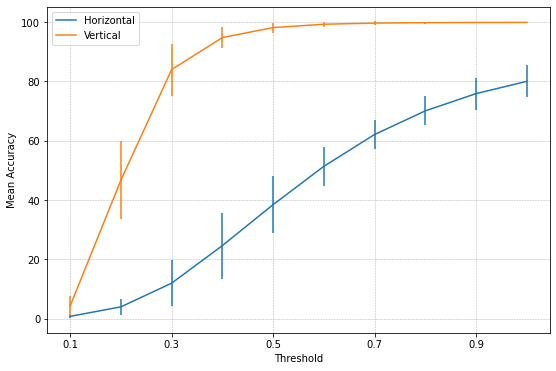

In [54]:
df_vert_hoz_plot = df_vert_hoz.loc[:, '0.1':'1.0']

ax = df_vert_hoz_plot.T.plot(figsize=(9,6), yerr=[hoz_err[:-2], vert_err[:-2]])
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Accuracy')
ax.grid(linestyle='--', linewidth=0.5)

<AxesSubplot:>

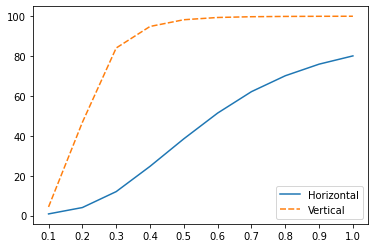

In [23]:
sns.lineplot(data=df_vert_hoz_plot.T)